In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from transformers import AutoTokenizer, GPT2LMHeadModel, PhrasalConstraint, QuantoConfig

from analysis.toolbox import *
from undecorated import undecorated
from types import MethodType

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(device)
print(f"Using {device} device")
print(torch.tensor([1, 2, 3]).device)


# MAGICKS --------------------------
s_model = "gpt2"
iSeed = 4523522

iEncodingDim = 2
iOutputSize = 768
iMaxTokens = 15

torch.manual_seed(iSeed)
model = GPT2LMHeadModel.from_pretrained(s_model, device_map=device, resume_download=True)
tokenizer = AutoTokenizer.from_pretrained(s_model, resume_download=True)

# TODO: Link to this https://github.com/huggingface/transformers/issues/15552 (last comment)
generate_with_grad = model.generate.__closure__[1].cell_contents
#generate_with_grad = undecorated(model.generate)
model.generate_with_grad = MethodType(generate_with_grad, model)

if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token


Using mps device
mps:0


In [121]:
sPathGenerator = "../mlartifacts/337721250762804550/4c5cb926a7854be1bf6af4c2f6b505f7/artifacts/models/data/model.pth"
sPathPredictor = "classifier.pth"

# Load the Generator
$p(x)$

In [122]:
ae = torch.load(sPathGenerator)
generator = ae.decoder


# Load the Classifier
$p(y|x)$

In [266]:
# NOTE: Implement this more robustly; This must match the arch. in the classifier
# NOTE: Think about whether the generator training claims can be part of the class. training data
class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(input_size, 192)
        self.fc3 = nn.Linear(192, 48)
        self.fc3 = nn.Linear(192, 48)
        self.fc4 = nn.Linear(48, output_size)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# load model
classifier = torch.load(sPathPredictor)
#classifier.eval()

def fnPreProcessor(x):
    print(x.shape)
    # return shape: iClaims x iTokens x iEmbeddingSize
    tokens = model.generate_with_grad(inputs_embeds = x.unsqueeze(1),
               max_new_tokens = iMaxTokens,
               pad_token_id = tokenizer.pad_token_id)
    
    print(tokens)
    
    # apply the input embedding and mean pool across tokens
    tReturn = model.get_input_embeddings()(tokens).mean(dim=1)
    return tReturn

In [90]:
# BUG: Are these part of the classifier training data? For validation, they shouldn't be
lTargetStrings = [
    "Experience 50% more visible shine after just one use.", #0
    "Formulated with light-reflecting technology for a glossy finish.", #1
    "Transform dull strands into radiant, luminous locks.", #2
    "Infused with nourishing oils that enhance natural shine.", #3
    "See instant brilliance with our advanced shine-boosting formula.", #4
    "Locks in moisture to amplify hair's natural luster.", #5
    "Achieve salon-quality shine without leaving home.", #6
    "Visible reduction in dullness, replaced with stunning shine.", #7
    "Say goodbye to lackluster hair, hello to mirror-like shine.", #8
    "Clinically proven to enhance shine by up to 70%.", # ^tangible #9
    "Elevate your confidence with hair that gleams under any light.", #10
    "Embrace the allure of luminous hair that turns heads.", #11
    "Unleash the power of radiant hair that speaks volumes.", #12
    "Transform your look with hair that exudes brilliance.", #13
    "Feel the difference of hair that shines with vitality and health.", #14
    "Rediscover the joy of hair that beams with inner vibrancy.", #15
    "Indulge in the luxury of hair that shimmers with elegance.", #16
    "Step into the spotlight with hair that radiates beauty.", #17
    "Experience the magic of hair that dazzles with every movement.", #18
    "Unlock the secret to hair that shines from within, reflecting your inner glow." #19,
]

tTargetStrings, lLengths = TokenizeClaims(lTargetStrings, tokenizer)
tInputEmbeddings = model.get_input_embeddings()(tTargetStrings).mean(dim=1)

_, prediction = torch.max(classifier(tInputEmbeddings), 1)

print(((prediction[:10] == 1).sum() + (prediction[10:] == 0).sum()) / 20)

tensor(0.7500, device='mps:0')


# Morpher


In [91]:
tGenerationPoint = torch.tensor(torch.randn(1, 2), requires_grad=True)

/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [126]:
tGenerationPoint, tGenerationPoint.shape

print(tokenizer.decode(model.generate(inputs_embeds = generator(tGenerationPoint).unsqueeze(1),
               max_new_tokens = iMaxTokens,
               pad_token_id = tokenizer.pad_token_id)[0]))

Experience 50

% ( image only sees best for less<|endoftext|>


In [93]:
tOutputGenerator = generator(tGenerationPoint)
tOutputGenerator.shape

torch.Size([1, 768])

## Classification

In [94]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)

/Users/hoener/miniforge3/envs/mphil/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


torch.Size([1, 1, 768])
tensor([[ 8479,  4817,    12,   259,    12, 43701,    13, 50256]],
       device='mps:0')
torch.Size([1, 768])
tensor([2.8088e-09], device='mps:0', grad_fn=<SelectBackward0>)
tensor([1.], device='mps:0', grad_fn=<AbsBackward0>)
torch.Size([1, 1, 768])
tensor([[ 8479,  4817,    12,   259,    12, 43701,    13, 50256]],
       device='mps:0')
torch.Size([1, 768])
tensor([2.8088e-09], device='mps:0', grad_fn=<SelectBackward0>)
tensor([1.], device='mps:0', grad_fn=<AbsBackward0>)
torch.Size([1, 1, 768])
tensor([[ 8479,  4817,    12,   259,    12, 43701,    13, 50256]],
       device='mps:0')
torch.Size([1, 768])
tensor([2.8088e-09], device='mps:0', grad_fn=<SelectBackward0>)
tensor([1.], device='mps:0', grad_fn=<AbsBackward0>)
torch.Size([1, 1, 768])
tensor([[ 8479,  4817,    12,   259,    12, 43701,    13, 50256]],
       device='mps:0')
torch.Size([1, 768])
tensor([2.8088e-09], device='mps:0', grad_fn=<SelectBackward0>)
tensor([1.], device='mps:0', grad_fn=<AbsBack

KeyboardInterrupt: 

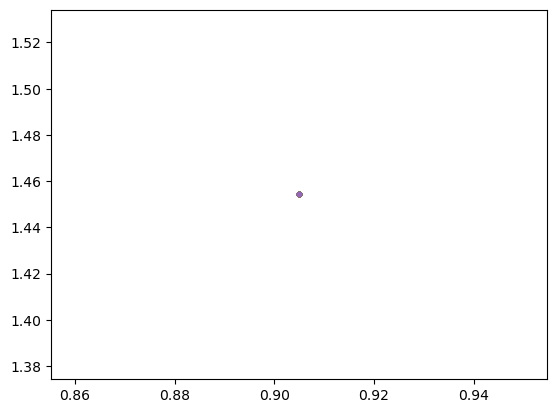

In [327]:
# setup
dLearningRate = 1e-5
tGenerationPoint = torch.tensor(torch.randn(1, 2))
tTestPoint = model.get_input_embeddings()(tokenizer.encode("Feel the confidence and allure", return_tensors="pt")).mean(dim=1).detach()
#tGenerationPoint = torch.tensor(tInitPoint, requires_grad=True)
optimizer = torch.optim.Adam([tTestPoint], lr=dLearningRate, maximize=False)
criterion = torch.nn.MSELoss()

plt.plot(tGenerationPoint.detach().cpu().numpy()[0, 0],
         tGenerationPoint.detach().cpu().numpy()[0, 1], '.')

iClassIdx = 1
iEpoch = 0
iEpochMax = 100 # failswitch
dCriterion = 1e-1 # when class 1 probability above dCriterion, stop
iTargetValue = torch.tensor([1])

# start optimization
while True:
    
    iEpoch += 1
    
    # generate from point
    tOutputGenerator = generator(tGenerationPoint).unsqueeze(1)
    print(tOutputGenerator.shape)
    # tOld = tGenerationPoint.clone()

    # # make prediction based on the sequence from this point
    # # BUG: Can I switch this for generate_with_grad?
    # # BUG: Argmax could be the problem ...
    # for i in range(1, iMaxTokens + 1):
    #     if i == 1:
    #         logits = model(inputs_embeds = tOutputGenerator).logits
    #         tNextEmbedding = torch.stack((tOutputGenerator.squeeze(), model.get_input_embeddings()(torch.argmax(logits))), dim=0)
    #     else:
    #         tOldEmbedding = tNextEmbedding.clone()
    #         logits = model(inputs_embeds = tNextEmbedding).logits
    #         tNextEmbedding = torch.cat((tOldEmbedding, model.get_input_embeddings()(torch.argmax(logits)).unsqueeze(0)), dim=0)
    
    out = model.generate_with_grad(inputs_embeds = tOutputGenerator,
               max_new_tokens = iMaxTokens,
               pad_token_id = tokenizer.pad_token_id)
    print(out)
    # tInputClassifier = tNextEmbedding.clone()
    # # apply the input embedding and mean pool across tokens
    #tInputClassifier = model.get_input_embeddings()(tokens).mean(dim=1)
    # iInputClassifier = fnPreProcessor(tOutputGenerator)
    print(iInputClassifier.shape)
    tOutputClassifier = classifier(tTestPoint)
    # perform optimizer step from here
    optimizer.zero_grad()
    print(tOutputClassifier[:, iClassIdx])
    distance = torch.abs(1 - tOutputClassifier[:, iClassIdx])
    print(distance)
    #distance = torch.norm(torch.ones([1, 2]) - tOutputClassifier)

    distance.backward(retain_graph=True)
    #print("value", tOutputClassifier[:, iClassIdx])
    #print("distance", distance.item())
    #print("point", tGenerationPoint.detach().cpu().numpy())
    optimizer.step()

    plt.plot(tGenerationPoint.detach().cpu().numpy()[0, 0], tGenerationPoint.detach().cpu().numpy()[0, 1], '.')
    #plt.show()
    
    if distance < dCriterion:
        break
    
    if iEpoch >= iEpochMax:
        break
    

In [ ]:
aNewClaim = tOutputGenerator.detach().cpu().numpy()
plt.plot(aNewClaim[0, 0], aNewClaim[0, 1])
plt.show()

# Regression

In [ ]:
# setup
dLearningRate = 1e-1
tGenerationPoint = torch.tensor(torch.randn(1, 2), requires_grad=True)
optimizer = torch.optim.Adam([tGenerationPoint], lr=dLearningRate, maximize=False)
criterion = torch.nn.MSELoss()

plt.plot(tGenerationPoint.detach().cpu().numpy()[0, 0],
         tGenerationPoint.detach().cpu().numpy()[0, 1])
plt.show()

iClassIdx = 1
iEpoch = 0
iEpochMax = 1000 # failswitch
dCriterion = 9e-1 # allowed distance loss between target and generated
dTargetValue = 2

# start optimization
while True:
    
    iEpoch += 1
    
    # generate from point
    tOutputGenerator = generator(tGenerationPoint)
    
    # make prediction based on the sequence from this point
    tOutputRegressor = regressor(fnPreProcessor(tOutputGenerator))
    
    # perform optimizer step from here
    optimizer.zero_grad()
    distance = criterion(tOutputRegressor, dTargetValue)
    distance.backward()
    optimizer.step()
    
    print(distance)
    plt.plot(tGenerationPoint.detach().cpu().numpy()[0, 0], tGenerationPoint.detach().cpu().numpy()[0, 1])
    plt.show()
    
    if distance > dCriterion:
        break
    
    if iEpoch >= iEpochMax:
        break